In [4]:
pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 48.9 MB/s eta 0:00:00


In [5]:
#setup the matplotlib graphics library and configure it to show
# figures inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import *
# make qutip available in the rest of the notebook
from qutip import *
from matplotlib import animation as animation, pyplot as plt, cm
from IPython import display
from IPython.display import HTML




def Opera(dim,S):
    if S==1:
        jj=jmat(1)
        jx,jy,jz=jmat(1)
        jp=jmat(1,'+')
        jm=jmat(1,'-')
        sx = tensor(qeye(dim), jx)
        sy = tensor(qeye(dim), jy)
        sz = tensor(qeye(dim), jz)
        sm = tensor(qeye(dim), jm)
        sp = sm.dag()
        a = tensor(destroy(dim), qeye(3))
        ad = a.dag()
        ids = tensor(qeye(dim), qeye(3))
    else:

        sx = tensor(qeye(dim), sigmax())
        sy = tensor(qeye(dim), sigmay())
        sz = tensor(qeye(dim), sigmaz())
        sm = tensor(qeye(dim), sigmam())
        sp = sm.dag()
        a = tensor(destroy(dim), qeye(2))
        ad = a.dag()
        ids = tensor(qeye(dim), qeye(2))

    return sm, sp, sx, sy, sz, a, ad, ids


def drive_coeff(t, args):
    return Omega * exp(-1j * delta * t)

def drive_coeff_conj(t, args):
    return conj(Omega) * exp(1j * delta * t)


def drive_sq(t, args):
    return Omegap * exp(-2j * wp * t)

def drive_sq_conj(t, args):
    return conj(Omegap) * exp(2j * wp * t)




def compute_expectations(states, observables):
    """
    Compute the expectation values of given observables for a list of states.

    Parameters:
    - states: A list of Qobj states, typically the result of a mesolve.
    - observables: A list of Qobj observables for which to compute expectation values.

    Returns:
    - A list of lists, where each sublist contains the expectation values of an observable over time.
    """
    # Initialize a list to store the expectation values for each observable
    expectation_values = [[] for _ in observables]

    # Loop over each state
    for state in states:
        # Loop over each observable
        for i, obs in enumerate(observables):
            # Calculate and store the expectation value
            expectation_values[i].append(qutip.expect(obs, state))

    return expectation_values


def generate_c_ops(gammam, gammas, gammaa, gamma_l, n_th_a, sp_th_a, a, sz, sm, sp, include_lasing=False):
    """
    Generate collapse operators based on provided rates and conditions.

    Parameters:
    - gammam: Rate for cavity relaxation and excitation.
    - gammas: Rate for qubit relaxation.
    - gammaa: Rate for additional qubit dynamics.
    - gamma_l: Rate for lasing.
    - n_th_a: Thermal occupation number for cavity.
    - sp_th_a: Thermal occupation number for qubit.
    - a: Annihilation operator for the cavity.
    - sz, sm, sp: Pauli operators or equivalent for the qubit.
    - include_lasing: Boolean to include lasing in the collapse operators.

    Returns:
    - A list of collapse operators.
    """
    c_ops = []
    # Cavity relaxation
    rate = gammam * (1 + n_th_a)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a)
    # Cavity excitation, if temperature > 0
    rate = gammam * n_th_a
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a.dag())
    # Qubit relaxation
    rate = gammas
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sz)
    rate = gammaa * (1 + sp_th_a)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sm)
    rate = gammaa * sp_th_a
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sp)
    # Lasing
    if include_lasing:
        rate = gamma_l
        if rate > 0.0:
            c_ops.append(sqrt(rate) * sm)

    return c_ops



def plot_wigner_functions(all_states, times, all_times, mode='a', xvec=linspace(-15, 15, 200)):
    """
    Plot Wigner functions for specified states at given times.

    :param all_states: Concatenated states from all phases of evolution.
    :param mode: 'a' for the resonator or 's' for the spin.
    :param times: Array of times to plot Wigner functions for.
    :param xvec: Phase space range for Wigner function calculation.
    """
    for t in times:
        # Find the closest time index
        index = (abs(all_times - t)).argmin()
        rho = all_states[index]

        # Trace out the appropriate mode
        if mode == 'a':
            rho_reduced = rho.ptrace(0)  # For resonator
        elif mode == 's':
            rho_reduced = rho.ptrace(1)  # For spin
        else:
            raise ValueError("Invalid mode. Use 'a' or 's'.")

        # Calculate the Wigner function
        W = wigner(rho_reduced, xvec, xvec)

        # Plotting
        plt.figure(figsize=(8, 6))
        plt.contourf(xvec, xvec, W, 100, cmap='RdBu', norm=plt.Normalize(-0.1, 0.1))
        plt.colorbar()
        plt.title(f'Wigner function of mode {mode} at t={t:.2f}')
        plt.xlabel('Quadrature X')
        plt.ylabel('Quadrature P')
        plt.show()



def plot_hist(all_states, times, all_times, num_ticks=10, tick_rotation=90, figsize=(12, 6), tick_spacing=5):
    """
    Plot the histogram of state populations over time with specified x-ticks.

    Parameters:
    - all_states: List of Qobj states to plot.
    - times: List of times corresponding to each state.
    - num_ticks: Number of x-ticks to display on the plot. Default is 10.
    - tick_rotation: Degree of rotation for x-ticks. Default is 90.
    - figsize: Tuple representing the figure size. Default is (12, 6).
    - tick_spacing: Number of states between ticks on x-axis. Default is 5.
    """
    plt.figure(figsize=figsize)

    for t in times:

        index = (abs(all_times - t)).argmin()
        rho = all_states[index]
        # Assume 'state' is a Qobj for a density matrix, and we need the diagonal
        rho_reduced = rho.ptrace(0)  # Adjust if tracing over a different subsystem
        populations = rho_reduced.diag()

        # Prepare the figure
        plt.clf()  # Clear the current figure
        plt.bar(arange(len(populations)), populations)

        # Set the x-ticks to be sparse based on tick_spacing
        plt.xticks(arange(0, len(populations), tick_spacing), rotation=tick_rotation)

        # Labeling the plot
        plt.title(f'Population histogram at t={t:.2f}')
        plt.xlabel('State')
        plt.ylabel('Population')
        plt.draw()  # Draw the current frame
        plt.pause(0.1)  # Pause briefly to display the plot

    plt.show()
# Example usage
# Assuming 'all_states' is a list of QuTiP Qobj states and 'times' is a list of time points
# plot_hist(all_states, times)


def compute_heat_from_liouvillian(d_rho_dt, H, times):
    # Compute the trace of the product at each time step
    trace_values = [trace(d_rho_dt[i].full().dot(H.full())).real for i in range(len(times))]

    # Use the cumulative trapezoidal rule for numerical integration
    Q_t = cumtrapz(trace_values, times, initial=0)
    return Q_t



def plot_heat_contributions(Q_list, t):
    plt.figure(figsize=(12, 6))
    for i, Q in enumerate(Q_list):
        plt.plot(t[:len(Q)], Q, label=f'Contribution {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Heat contribution')
    plt.legend()
    plt.show()



def evolst(H, psi0, t, cops, observables):
    opts = Options(store_states=True)
    result = mesolve(H, psi0, t, cops, [], args={}, options=opts)
    exp_vals = compute_expectations(result.states, observables)

    return result, exp_vals





def Cyclevol(rho0, hamiltonian_time_pairs, c_ops_list, observables):
    """
    Perform a sequence of time evolutions on an initial state with different Hamiltonians
    and return individual heat contributions for each term in the collapse operators.

    Parameters:
    - rho0: Initial state (Qobj)
    - hamiltonian_time_pairs: List of tuples (H, tlist) for each evolution segment
    - c_ops_list: List of lists of collapse operators corresponding to each Hamiltonian
    - observables: List of observables (Qobj) to compute expectation values

    Returns:
    - all_states: Concatenated list of states from all evolution segments
    - all_times: Concatenated array of time points from all evolution segments
    - all_exp_vals: Concatenated expectation values for each observable over time
    - EntropyM: List of von Neumann entropy values for mechanical part over time
    - EntropyS: List of von Neumann entropy values for spin part over time
    - total_Q_terms_list: List of lists of individual heat contributions for each term in the collapse operators
    """
    all_states = []
    all_times = array([])
    all_exp_vals = [[] for _ in observables]
    current_state = rho0
    EntropyM = []
    EntropyS = []
    total_Q_terms_list = None  # Changed to None for clearer initialization logic

    for i, ((H, tlist), c_ops) in enumerate(zip(hamiltonian_time_pairs, c_ops_list)):
#         result, exp_vals, Q_terms = evolst(H, current_state, tlist, c_ops, observables)
        result, exp_vals = evolst(H, current_state, tlist, c_ops, observables)

        all_states.extend(result.states)

        if i == 0:
            all_times = array(tlist)
        else:
            # Ensure continuity in time by adding the last time from all_times
            all_times = concatenate((all_times, all_times[-1] + tlist))

        for j, exp_val in enumerate(exp_vals):
            all_exp_vals[j].extend(exp_val)

        for state in result.states:
            EntropyM.append(entropy_vn(state.ptrace(0), base=e))
            EntropyS.append(entropy_vn(state.ptrace(1), base=e))

        current_state = result.states[-1]

    return all_states, all_times, all_exp_vals, EntropyM, EntropyS


# def wtp(t, args):
#     return wt*t + wm
# # def wtm(t, args):
# #     return wt*(t-T) + wm

# def wtm(t, args):
#     return wt*(T-t)+ wm

# def gtm(t, args):
#     return g*sqrt(wm/abs(wt*(T-t) + wm))
# def gtp(t, args):
#     return g*sqrt(wm/abs(wt*t + wm))

def wtp(t, args):
    return wt*(t-T) + wm
# def wtm(t, args):
#     return wt*(t-T) + wm

def wtm(t, args):
    return -wt*t+ wm

def gtm(t, args):
    return g*sqrt(wm/abs(-wt*t + wm))
def gtp(t, args):
    return g*sqrt(wm/abs(wt*(t-T) + wm))


def Temperature(ni,wi):
    return (wi/kb)/(log(1+1/ni))


def CycleCool(rho0, hamiltonian_time_pairs, c_ops_list, observables, Ncycles):

    current_rho = rho0
    t=array([0])
    allst=[current_rho]
    rho_mech = current_rho.ptrace(0)
    rho_spin = current_rho.ptrace(1)
    EntropyM=[entropy_vn(rho_mech, base=e)]
    EntropyS=[entropy_vn(rho_spin, base=e)]



    for i in range(Ncycles):

#         if i==0:
#              t=array([0])
        rhot = current_rho.ptrace(0)
        rhoc, tt, exp_vals, entropyM, entropyS = Cyclevol(current_rho, hamiltonian_time_pairs, c_ops_list, observables)
        EntropyM=concatenate((EntropyM,entropyM), axis=0)
        EntropyS=concatenate((EntropyS,entropyS), axis=0)
        allst=allst+rhoc
        t=concatenate((t, tt + (t[-1] if i > 0 else 0)))

        current_rho=rhoc[-1]
        print(i)

    return t, allst, EntropyM, EntropyS







In [21]:
#setup the matplotlib graphics library and configure it to show
# figures inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import *
# make qutip available in the rest of the notebook
from qutip import *
from matplotlib import animation as animation, pyplot as plt, cm
from IPython import display
from IPython.display import HTML




def Opera(dim,S):
    if S==1:
        jj=jmat(1)
        jx,jy,jz=jmat(1)
        jp=jmat(1,'+')
        jm=jmat(1,'-')
        sx = tensor(qeye(dim), jx)
        sy = tensor(qeye(dim), jy)
        sz = tensor(qeye(dim), jz)
        sm = tensor(qeye(dim), jm)
        sp = sm.dag()
        a = tensor(destroy(dim), qeye(3))
        ad = a.dag()
        ids = tensor(qeye(dim), qeye(3))
    else:

        sx = tensor(qeye(dim), sigmax())
        sy = tensor(qeye(dim), sigmay())
        sz = tensor(qeye(dim), sigmaz())
        sm = tensor(qeye(dim), sigmam())
        sp = sm.dag()
        a = tensor(destroy(dim), qeye(2))
        ad = a.dag()
        ids = tensor(qeye(dim), qeye(2))

    return sm, sp, sx, sy, sz, a, ad, ids


def drive_coeff(t, args):
    return Omega * exp(-1j * delta * t)

def drive_coeff_conj(t, args):
    return conj(Omega) * exp(1j * delta * t)


def drive_sq(t, args):
    return Omegap * exp(-2j * wp * t)

def drive_sq_conj(t, args):
    return conj(Omegap) * exp(2j * wp * t)




def compute_expectations(states, observables):
    """
    Compute the expectation values of given observables for a list of states.

    Parameters:
    - states: A list of Qobj states, typically the result of a mesolve.
    - observables: A list of Qobj observables for which to compute expectation values.

    Returns:
    - A list of lists, where each sublist contains the expectation values of an observable over time.
    """
    # Initialize a list to store the expectation values for each observable
    expectation_values = [[] for _ in observables]

    # Loop over each state
    for state in states:
        # Loop over each observable
        for i, obs in enumerate(observables):
            # Calculate and store the expectation value
            expectation_values[i].append(qutip.expect(obs, state))

    return expectation_values


def generate_c_ops(gammam, gammas, gammaa, gamma_l, n_th_a, sp_th_a, a, sz, sm, sp, include_lasing=False):
    """
    Generate collapse operators based on provided rates and conditions.

    Parameters:
    - gammam: Rate for cavity relaxation and excitation.
    - gammas: Rate for qubit relaxation.
    - gammaa: Rate for additional qubit dynamics.
    - gamma_l: Rate for lasing.
    - n_th_a: Thermal occupation number for cavity.
    - sp_th_a: Thermal occupation number for qubit.
    - a: Annihilation operator for the cavity.
    - sz, sm, sp: Pauli operators or equivalent for the qubit.
    - include_lasing: Boolean to include lasing in the collapse operators.

    Returns:
    - A list of collapse operators.
    """
    c_ops = []
    # Cavity relaxation
    rate = gammam * (1 + n_th_a)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a)
    # Cavity excitation, if temperature > 0
    rate = gammam * n_th_a
    if rate > 0.0:
        c_ops.append(sqrt(rate) * a.dag())
    # Qubit relaxation
    rate = gammas
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sz)
    rate = gammaa * (1 + sp_th_a)
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sm)
    rate = gammaa * sp_th_a
    if rate > 0.0:
        c_ops.append(sqrt(rate) * sp)
    # Lasing
    if include_lasing:
        rate = gamma_l
        if rate > 0.0:
            c_ops.append(sqrt(rate) * sm)

    return c_ops

def evolst(H, psi0, t, cops, observables):
    opts = Options(store_states=False, store_final_state=True)
    result = mesolve(H, psi0, t, cops, e_ops=observables, options=opts)
    return result.final_state, result.expect

def Cyclevol(rho0, hamiltonian_time_pairs, c_ops_list, observables, t_offset=0.0):
    all_exp_vals = [[] for _ in observables]
    EntropyM = []
    EntropyS = []
    all_t = []

    current_state = rho0
    current_offset = t_offset

    for (H, tlist), c_ops in zip(hamiltonian_time_pairs, c_ops_list):
        shifted_tlist = [t + current_offset for t in tlist]

        final_state, exp_vals = evolst(H, current_state, tlist, c_ops, observables)

        for j, exp in enumerate(exp_vals):
            all_exp_vals[j].extend(exp)

        for _ in shifted_tlist:
            rho_mech = current_state.ptrace(0)
            rho_spin = current_state.ptrace(1)
            EntropyM.append(entropy_vn(rho_mech, base=e))
            EntropyS.append(entropy_vn(rho_spin, base=e))

        all_t.extend(shifted_tlist)
        current_offset = shifted_tlist[-1]
        current_state = final_state

    return current_state, all_exp_vals, EntropyM, EntropyS, all_t, current_offset

def CycleCool(rho0, hamiltonian_time_pairs, c_ops_list, observables, Ncycles):
    current_rho = rho0

    all_exp_vals = [[] for _ in observables]
    EntropyM = []
    EntropyS = []
    all_t = []
    t_offset = 0.0

    for i in range(Ncycles):
        current_rho, exp_vals, entM, entS, tlist, t_offset = Cyclevol(
            current_rho, hamiltonian_time_pairs, c_ops_list, observables, t_offset
        )

        for j, exp in enumerate(exp_vals):
            all_exp_vals[j].extend(exp)
        EntropyM.extend(entM)
        EntropyS.extend(entS)
        all_t.extend(tlist)

        print(f"Cycle {i+1} completed")

    return current_rho, all_exp_vals, EntropyM, EntropyS, all_t


def plot_wigner_functions(all_states, times, all_times, mode='a', xvec=linspace(-15, 15, 200)):
    """
    Plot Wigner functions for specified states at given times.

    :param all_states: Concatenated states from all phases of evolution.
    :param mode: 'a' for the resonator or 's' for the spin.
    :param times: Array of times to plot Wigner functions for.
    :param xvec: Phase space range for Wigner function calculation.
    """
    for t in times:
        # Find the closest time index
        index = (abs(all_times - t)).argmin()
        rho = all_states[index]

        # Trace out the appropriate mode
        if mode == 'a':
            rho_reduced = rho.ptrace(0)  # For resonator
        elif mode == 's':
            rho_reduced = rho.ptrace(1)  # For spin
        else:
            raise ValueError("Invalid mode. Use 'a' or 's'.")

        # Calculate the Wigner function
        W = wigner(rho_reduced, xvec, xvec)

        # Plotting
        plt.figure(figsize=(8, 6))
        plt.contourf(xvec, xvec, W, 100, cmap='RdBu', norm=plt.Normalize(-0.1, 0.1))
        plt.colorbar()
        plt.title(f'Wigner function of mode {mode} at t={t:.2f}')
        plt.xlabel('Quadrature X')
        plt.ylabel('Quadrature P')
        plt.show()



def plot_hist(all_states, times, all_times, num_ticks=10, tick_rotation=90, figsize=(12, 6), tick_spacing=5):
    """
    Plot the histogram of state populations over time with specified x-ticks.

    Parameters:
    - all_states: List of Qobj states to plot.
    - times: List of times corresponding to each state.
    - num_ticks: Number of x-ticks to display on the plot. Default is 10.
    - tick_rotation: Degree of rotation for x-ticks. Default is 90.
    - figsize: Tuple representing the figure size. Default is (12, 6).
    - tick_spacing: Number of states between ticks on x-axis. Default is 5.
    """
    plt.figure(figsize=figsize)

    for t in times:

        index = (abs(all_times - t)).argmin()
        rho = all_states[index]
        # Assume 'state' is a Qobj for a density matrix, and we need the diagonal
        rho_reduced = rho.ptrace(0)  # Adjust if tracing over a different subsystem
        populations = rho_reduced.diag()

        # Prepare the figure
        plt.clf()  # Clear the current figure
        plt.bar(arange(len(populations)), populations)

        # Set the x-ticks to be sparse based on tick_spacing
        plt.xticks(arange(0, len(populations), tick_spacing), rotation=tick_rotation)

        # Labeling the plot
        plt.title(f'Population histogram at t={t:.2f}')
        plt.xlabel('State')
        plt.ylabel('Population')
        plt.draw()  # Draw the current frame
        plt.pause(0.1)  # Pause briefly to display the plot

    plt.show()
# Example usage
# Assuming 'all_states' is a list of QuTiP Qobj states and 'times' is a list of time points
# plot_hist(all_states, times)


def compute_heat_from_liouvillian(d_rho_dt, H, times):
    # Compute the trace of the product at each time step
    trace_values = [trace(d_rho_dt[i].full().dot(H.full())).real for i in range(len(times))]

    # Use the cumulative trapezoidal rule for numerical integration
    Q_t = cumtrapz(trace_values, times, initial=0)
    return Q_t



def plot_heat_contributions(Q_list, t):
    plt.figure(figsize=(12, 6))
    for i, Q in enumerate(Q_list):
        plt.plot(t[:len(Q)], Q, label=f'Contribution {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Heat contribution')
    plt.legend()
    plt.show()



def wtp(t, args):
    return wt*(t-T) + wm
# def wtm(t, args):
#     return wt*(t-T) + wm

def wtm(t, args):
    return -wt*t+ wm

def gtm(t, args):
    return g*sqrt(wm/abs(-wt*t + wm))
def gtp(t, args):
    return g*sqrt(wm/abs(wt*(t-T) + wm))


def Temperature(ni,wi):
    return (wi/kb)/(log(1+1/ni))

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 750, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 820, in send
    msg = self.msg(
          ^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 661, in msg
    header = self.msg_header(msg_type) if header is None else header
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 644, in msg_header
    return msg_header(self.msg_id, msg_type, self.username, self.session)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 275, in msg_header
    date

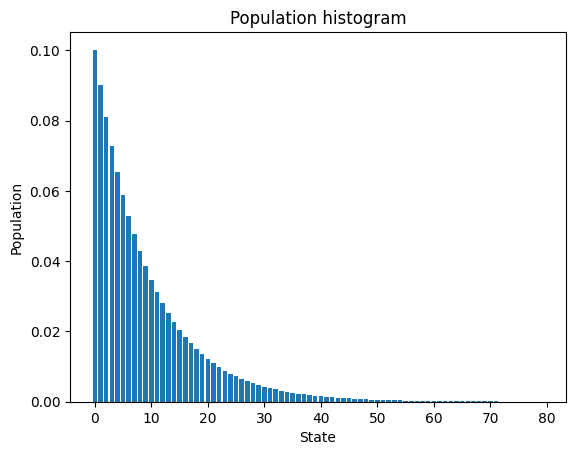

In [22]:
N =80
S=0.5

kb= 20836619120
wm = 50 * 2 * pi
# fx = 0.5*wm;
fy =  1*10**(6)
# g  = 3e10 *1e-9* 2 * pi*.22
g=0.71*wm
wt = 20000
T=0.5*pi/(wm)
wmin=(-wt*T + wm)
gmin=g*sqrt(wm/(-wt*T + wm))
fx = 0.5*wm;
Delta=5.85*wm

print([wt*(0-T) + wm,gmin,wt*T/wm])

######### Operators ##################
sm, sp, sx, sy, sz, a, ad, ids=Opera(N,S)
z = a+ad
p = 1j*(ad-a)
z2 = z**2
p2 = p**2


######### Damping rates for each mode
Qm=10000
gammam = 1*wm/Qm
# gammam = 1*10**(-1)
gammas = 1/(2.5*10**(-3))
gammaa = 1/(5*10**(-3))
gamma_l = 5/(10**(-6))
n_th_a = 8.     # avg number of thermal bath excitation
sp_th_a= 0.0001
n_th = n_th_a

c_ops1 = generate_c_ops(gammam, gammas, gammaa, gamma_l, n_th_a, sp_th_a, a, sz, sp, sm, include_lasing=False)
c_ops2 = generate_c_ops(gammam, gammas, gammaa, gamma_l, n_th_a, sp_th_a, a, sz, sp, sm, include_lasing=True)


######### Time evolutions ########


# Tpy = pi/(4*abs(fy))
# tfree = 10*pi/wmin
# tlase=1*10**(-6)

Tpy = pi/(2*abs(fy))
tfree = 1*pi/wmin
tfree2 = 2*tfree
# tfree = 5*0.019
# tlase=1*10**(-6)
tlase=5*10**(-5)

# T = tfree + Tpy + tlase
twm=linspace(0,T,500)
tpy = linspace(0, Tpy, 50)
tf1 = linspace(0, tfree, 150)
tgl = linspace(0, tlase, 50)


######## Hamiltonians
H    = Delta*(ids-sz)/2 + wm*ad*a - g*(ids-sz)*(a+ad)/2
Hmin = Delta*(ids-sz)/2 + wmin*ad*a - gmin*(ids-sz)*(a+ad)/2

H0tp = [ad*a, wtp]
H0tm = [ad*a, wtm]

Hintp =[0.5*(ids-sz)*(a+ad) , gtp]
Hintm =[0.5*(ids-sz)*(a+ad) , gtm]

Hp = [ Delta*(ids-sz)/2, H0tp, Hintp]
Hm = [ Delta*(ids-sz)/2, H0tm, Hintm]


# Hseq=[(Hmin+fx*sx, tf1), (Hmin+fx*sx, tgl)]
# c_ops_seq = [c_ops1, c_ops2]

Hseq=[(H+fx*sx, tf1), (H, tgl)]
c_ops_seq = [c_ops1, c_ops2]

# Hseq=[(Hmin - fy*sy+fx*sx, tpy), (Hmin+fx*sx, tf1), (Hmin+fx*sx, tgl)]
# c_ops_seq = [c_ops1, c_ops1, c_ops2]



observables =  [ad*a, z, p, z2, p2, a, a**2, sz, sx, sy, Hmin, H]


rho1=steadystate(Hmin, c_ops1)
exp1=compute_expectations([rho1], observables)

# Assume 'state' is a Qobj for a density matrix, and we need the diagonal
rho_reduced = rho1.ptrace(0)  # Adjust if tracing over a different subsystem
populations = rho_reduced.diag()

# Prepare the figure
plt.clf()  # Clear the current figure
plt.bar(arange(len(populations)), populations)


# Labeling the plot
plt.title(f'Population histogram')
plt.xlabel('State')
plt.ylabel('Population')
plt.draw()  # Draw the current frame

plt.show()


In [25]:
##cooling

rho_final, all_expectations, Smech, Sspin, timestamp = CycleCool(rho1, Hseq, c_ops_seq, observables, Ncycles=900)

nph, zm, pm, z2m, p2m, am, a2m, ns, sxm, sym, Emin, Em=  all_expectations


Cycle 1 completed
Cycle 2 completed
Cycle 3 completed
Cycle 4 completed
Cycle 5 completed


In [28]:
import pandas as pd


# Create array


# Convert to DataFrame
df = pd.DataFrame(timestamp)

# Save to Excel
df.to_excel("timelist.xlsx", index=False, header=False)

# Convert to DataFrame
df2 = pd.DataFrame(nph)

# Save to Excel
df2.to_excel("phonon_no_cooled.xlsx", index=False, header=False)
